# SPARC-4 Pipeline Tools
## Night of  ``2023-06-05`` - ``PHOTOMETRY``
***

This notebook shows an example of the full reduction of the SPARC4 data  in the [minidata package](https://drive.google.com/file/d/1tAVjyhYGMDcrU5sDdGCmd_f5HoazZ294/view?usp=drive_link) using the SPARC4 pipeline tools. 

* Author: Eder Martioli, LNA 18 Apr 2024

In [1]:
import os, sys
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.utils as s4utils
import glob
import warnings
warnings.filterwarnings('ignore')

## User inputs and initial setup

Before starting the reduction, we must configure a few parameters. The pipeline comes with default values for all parameters. To modify these, one can create and edit their own parameter file, then load it into the ``PARAMS_FILE`` variable. Alternatively, parameters can be changed by directly resetting the dictionary entry for a specific parameter, like this: ``p['PARAM_NAME'] = PARAM_NEW_VALUE``. See examples below.

In [2]:
# set night directory name
NIGHTDIR = '20230605'
# set raw data root directory
ROOTDATADIR =  "/Users/eder/Data/SPARC4/minidata/"
# set reduced data root directory
ROOTREDUCEDDIR = "/Users/eder/Data/SPARC4/minidata/reduced/"
# set reduced data root directory
PIPELINEDIR = "/Users/eder/sparc4-pipeline/"
# define path to default calibration directory
calibdb_dir = os.path.join(PIPELINEDIR, "calibdb/")

# set path to the parameters file:
#PARAMS_FILE = ""  # to use deafult values
PARAMS_FILE = "{}/user_files/my_params.yaml".format(PIPELINEDIR)

# set path to a target list file
# this is to force targets to be included in the source catalog in addition to those detected automatically
TARGET_LIST_FILE = os.path.join(PIPELINEDIR,"user_files/targets.csv")

# select a SPARC4 channel: 1 (g), 2 (r), 3 (i) or 4 (z)
CHANNEL = 2

# initialize pipeline parameters
p = s4pipelib.init_s4_p(NIGHTDIR,
                        ROOTDATADIR,
                        ROOTREDUCEDDIR,
                        print_report=False,
                        param_file=PARAMS_FILE)

# get data dir
datadir = p['data_directories'][CHANNEL-1]
# get reduce dir
reducedir = p['reduce_directories'][CHANNEL-1]

# to force reduction even if products already exist
FORCE = False

###############################################################
# Below are a few examples on how to manually reset parameters: 
###############################################################

# set astrometry reference image as the one for this channel
p["ASTROM_REF_IMG"] = os.path.join(calibdb_dir, p["ASTROM_REF_IMGS"][CHANNEL-1])

# to build stacks of 10 images instead of the default value of 16 images
p['NFILES_FOR_STACK'] = 10

# to change the S/N threshold for detecting sources
# -- note that lower values will result in more (fainter) sources being detected.
p['PHOT_THRESHOLD'] = 30

# uncomment below to print all parameters and their respective values:
#for key in p.keys():
#    print("p['{}']={}".format(key,p[key]))

***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

In this section we build the master bias and flat-field calibrations.

## Define input list and output product file names

In [3]:
# create a list of zeros for current detector mode
zero_list = glob.glob("{}/{}".format(datadir,"*zero*.fits"))

# define file name of master bias 
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# create a list of flats for current detector mode
flat_list = glob.glob("{}/{}".format(datadir,"*dflat*.fits"))

# define file name of master flat
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# Run master calibration

The master calibration routine combines a list of calibration files into a master calibration image.

In [4]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     force=FORCE)

bias files: 3
gain: 3.3 electron / adu
processing frame 1 of 3
processing frame 2 of 3


2024-04-18 16:23:19,391 astropop - INFO - Combining 3 images with median method.  [imcombine]


processing frame 3 of 3
Normalization mean value: 1650.6460764884941 electron


In [5]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     normalize=True, 
                                     force=FORCE)

flat files: 3
gain: 3.3 electron / adu
processing frame 1 of 3
processing frame 2 of 3


2024-04-18 16:23:19,837 astropop - INFO - Combining 3 images with median method.  [imcombine]


processing frame 3 of 3
Normalization mean value: 55943.00104351044 electron


# Plot master calibration results

Now, we plot the results to check if they look fine. 

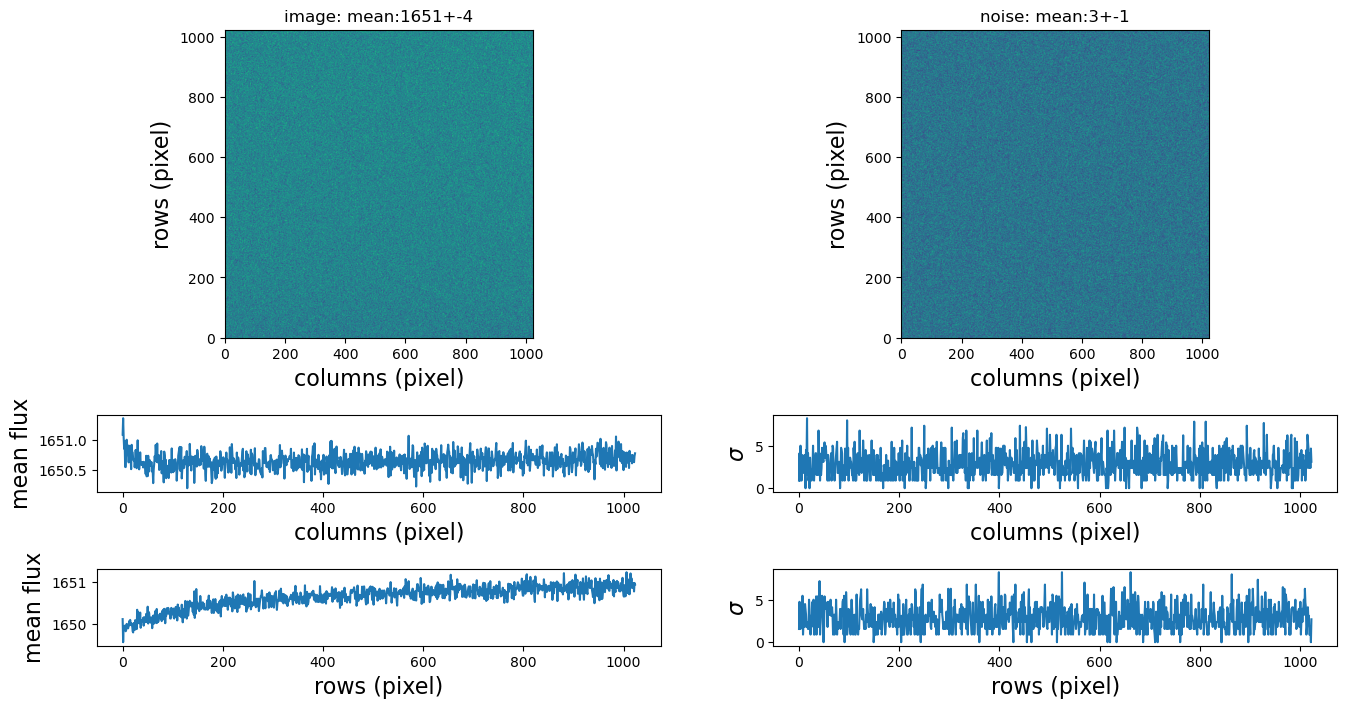

In [6]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

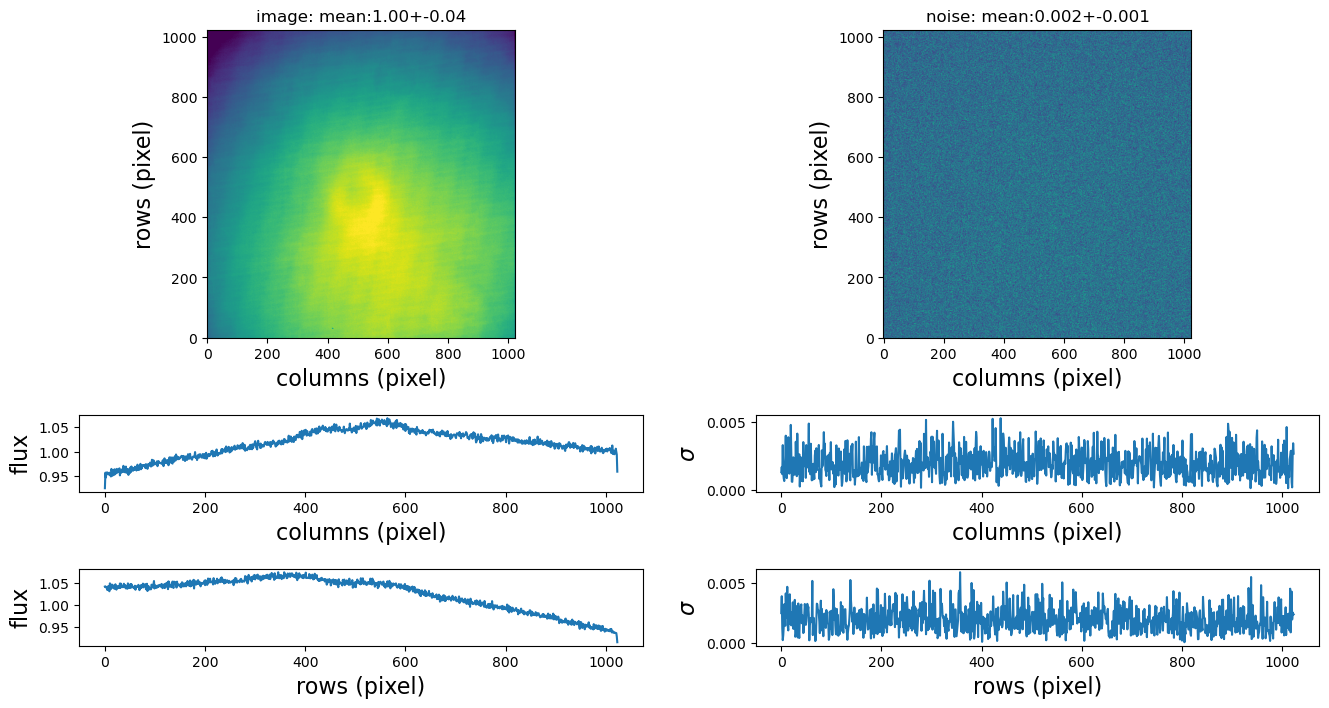

In [7]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)

***
# <font color='darkblue'>Science image reduction - Photometry </font> 

In this section we reduce the science data. In this example we show the reductiion processes for the following observations:

* The astrometric calibration field [CR3](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=14%3A38%3A08+-42%3A35%3A14&submit=SIMBAD+search) observed in photometric mode. 

### Select C3 data

In [8]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "CR3"  # LTT 4816 is a spectro-photometric standard

# set suffix for output stack filename
stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR, 
                                    CHANNEL, 
                                    OBJECTID.replace(" ",""))
# create a list of science data 
sci_list = glob.glob("{}/{}".format(datadir,"*cr3.fits"))

### Reduce scientific exposures in `PHOTOMETRIC` mode

To reduce scientific frames, run the routine ``s4pipelib.stack_and_reduce_sci_images``. This routine performs calibration for detector gain, bias, and flat-field. Then, a subset of frames is stacked to generate a stack product. Source detection is then conducted within the stack frame, and the identified sources are cross-referenced with a catalog to establish an astrometric solution and generate a master catalog for all input observations of this field. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into ``proc.fits`` product FITS files.

0 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001083_cr3.fits
OBJECT files: 10
Loading science frames to memory ... 
gain: 3.3 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 10 : 20230605_s4c2_001083_cr3.fits 
Calibrating science frame 2 of 10 : 20230605_s4c2_001082_cr3.fits 
Calibrating science frame 3 of 10 : 20230605_s4c2_001076_cr3.fits 
Calibrating science frame 4 of 10 : 20230605_s4c2_001077_cr3.fits 
Calibrating science frame 5 of 10 : 20230605_s4c2_001080_cr3.fits 
Calibrating science frame 6 of 10 : 20230605_s4c2_001081_cr3.fits 
Calibrating science frame 7 of 10 : 20230605_s4c2_001078_cr3.fits 
Calibrating science frame 8 of 10 : 20230605_s4c2_001079_cr3.fits 
Calibrating science frame 9 of 10 : 20230605_s4c2_001075_cr3.fits 
Calibrating science frame 10 of 10 : 20230605_s4c2_001074_cr3.fits 


2024-04-18 16:23:24,698 astropop - INFO - Registering image 1 from 10  [register]
2024-04-18 16:23:24,701 astropop - INFO - Images are equal, skipping registering.  [register]
2024-04-18 16:23:24,807 astropop - INFO - Registering image 2 from 10  [register]


Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001083_cr3.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001082_cr3.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001076_cr3.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001077_cr3.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001080_cr3.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001081_cr3.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001078_cr3.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001079_cr3.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001075_cr3.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001074_cr3.fits


2024-04-18 16:23:24,906 astropop - INFO - Filling registered image with cval=266.06  [register]
2024-04-18 16:23:24,912 astropop - INFO - Registering image with: translation=[-0.75  0.75], rotation=0.00°  [register]
2024-04-18 16:23:26,390 astropop - INFO - Registering image 3 from 10  [register]
2024-04-18 16:23:26,853 astropop - INFO - Filling registered image with cval=271.36  [register]
2024-04-18 16:23:26,857 astropop - INFO - Registering image with: translation=[-0.25  1.75], rotation=0.00°  [register]
2024-04-18 16:23:28,057 astropop - INFO - Registering image 4 from 10  [register]
2024-04-18 16:23:28,364 astropop - INFO - Filling registered image with cval=267.98  [register]
2024-04-18 16:23:28,365 astropop - INFO - Registering image with: translation=[-0.   1.5], rotation=0.00°  [register]
2024-04-18 16:23:28,962 astropop - INFO - Registering image 5 from 10  [register]
2024-04-18 16:23:29,249 astropop - INFO - Filling registered image with cval=266.32  [register]
2024-04-18 1

Creating new catalog of detected sources:
Solving astrometry in PHOT-MODE using astrometry_from_existing_wcs()
Running photometry for multiple apertures:
Aperture radius of 6 pixels: 1 of 6 :
Aperture radius of 8 pixels: 2 of 6 :
Aperture radius of 10 pixels: 3 of 6 :
Aperture radius of 12 pixels: 4 of 6 :
Aperture radius of 14 pixels: 5 of 6 :
Aperture radius of 16 pixels: 6 of 6 :
The 10 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 10 ... 
OBJECT files: 10
Creating output list of processed science frames ... 
1 of 10 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs2//20230605/20230605_s4c2_001083_cr3_proc.fits
2 of 10 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs2//20230605/20230605_s4c2_001082_cr3_proc.fits
3 of 10 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs2//20230605/20230605_s4c2_001076_cr3_proc.fits
4 of 10 is reduced? False -> /Users/eder/Data

2024-04-18 16:23:43,740 astropop - INFO - Computing shift of image 1 from 10  [register]
2024-04-18 16:23:43,740 astropop - INFO - Computing shift of image 2 from 10  [register]
2024-04-18 16:23:43,818 astropop - INFO - Computing shift of image 3 from 10  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001083_cr3.fits


2024-04-18 16:23:43,948 astropop - INFO - Computing shift of image 4 from 10  [register]
2024-04-18 16:23:44,054 astropop - INFO - Computing shift of image 5 from 10  [register]
2024-04-18 16:23:44,160 astropop - INFO - Computing shift of image 6 from 10  [register]
2024-04-18 16:23:44,278 astropop - INFO - Computing shift of image 7 from 10  [register]
2024-04-18 16:23:44,384 astropop - INFO - Computing shift of image 8 from 10  [register]
2024-04-18 16:23:44,491 astropop - INFO - Computing shift of image 9 from 10  [register]
2024-04-18 16:23:44,580 astropop - INFO - Computing shift of image 10 from 10  [register]


Processing file: 20230605_s4c2_001083_cr3.fits
Running aperture photometry for catalogs with an offset of dx=0.0 dy=0.0
Saving frame 1 of 10: /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001083_cr3.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs2//20230605/20230605_s4c2_001083_cr3_proc.fits
Processing file: 20230605_s4c2_001082_cr3.fits
Running aperture photometry for catalogs with an offset of dx=-0.75 dy=0.75
Saving frame 2 of 10: /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001082_cr3.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs2//20230605/20230605_s4c2_001082_cr3_proc.fits
Processing file: 20230605_s4c2_001076_cr3.fits
Running aperture photometry for catalogs with an offset of dx=-0.25 dy=1.75
Saving frame 3 of 10: /Users/eder/Data/SPARC4/minidata//sparc4acs2/20230605/20230605_s4c2_001076_cr3.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs2//20230605/20230605_s4c2_001076_cr3_proc.fits
Processing fi

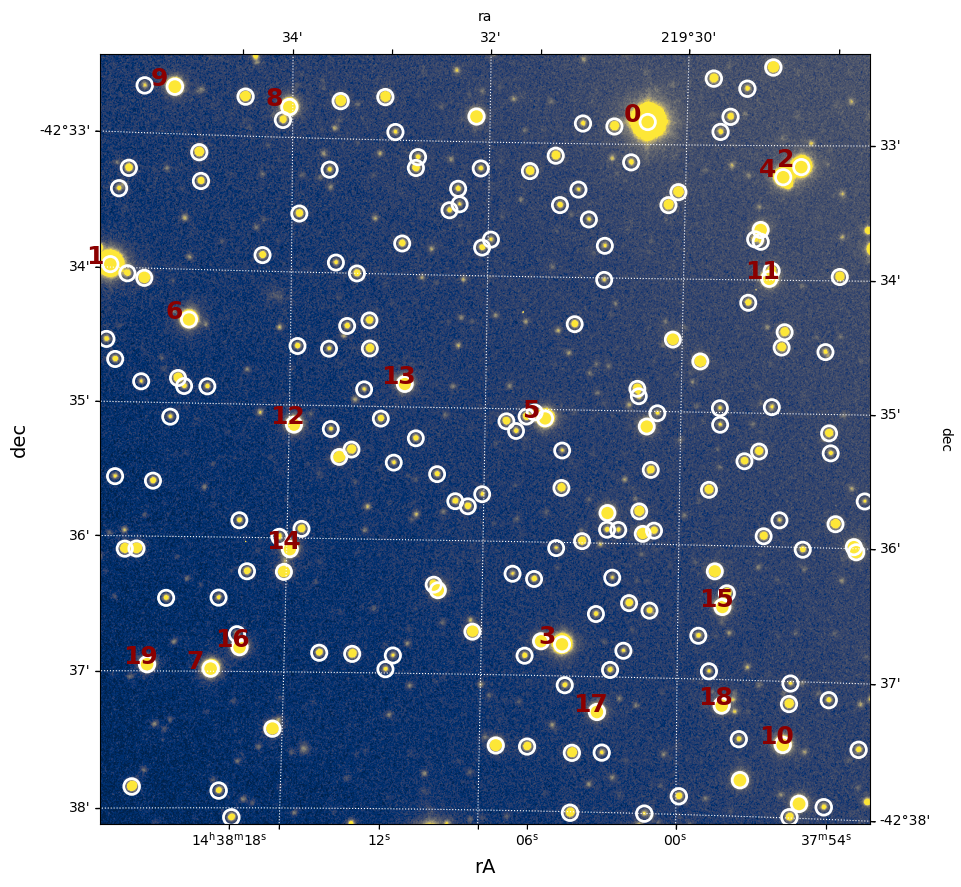

In [9]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          sci_list,
                                          reducedir,
                                          stack_suffix=stack_suffix,
                                          force=FORCE,
                                          verbose=True,
                                          plot=True) 

### PLOT results

The function ``s4plt.plot_sci_frame`` can be used to plot ``proc.fits`` or ``stack.fits`` products, as in the example below.  

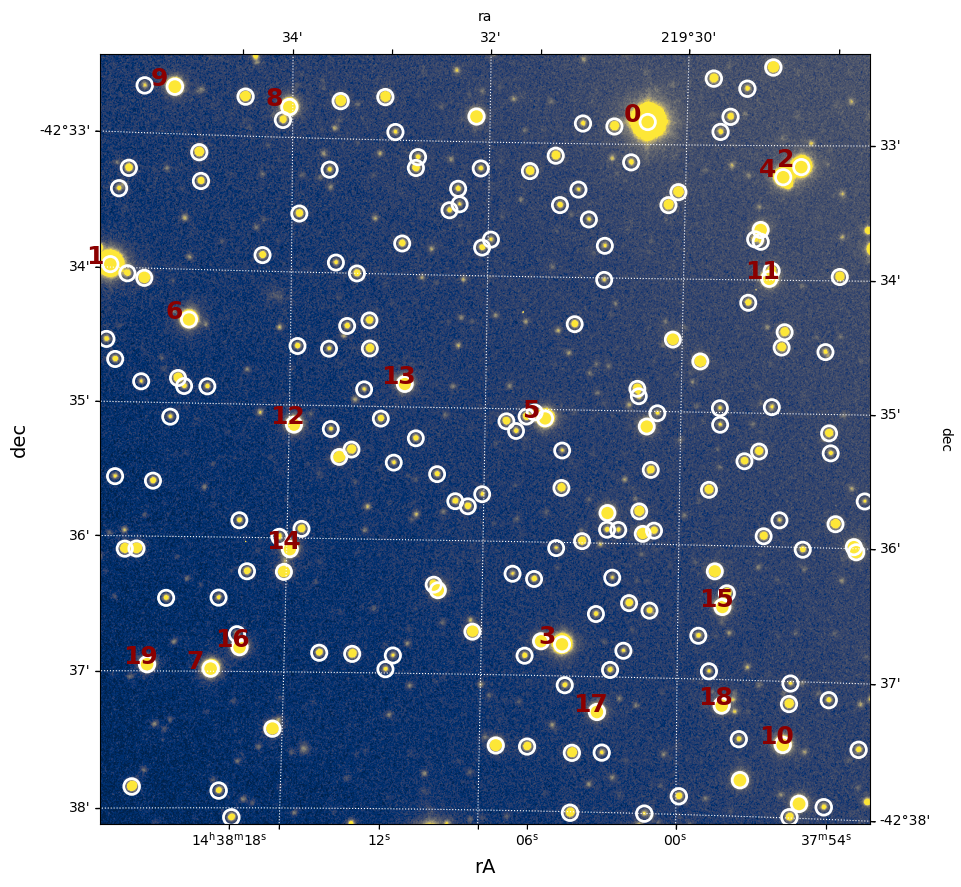

In [10]:
s4plt.plot_sci_frame(p['OBJECT_STACK'], cat_ext=3, nstars=20, use_sky_coords=True)

## Time series of `PHOTOMETRY` data : `light curve`

In this section, we compile all photometric information from the reduced ``proc.fits`` frames into a photometric time series product (`light curve`) using the routine ``s4pipelib.phot_time_series``. For this example, since there are only a few frames, the time series is not particularly interesting, as it contains only a few points in the time series.

In [11]:
ts_suffix = "{}_s4c{}_{}".format(NIGHTDIR, CHANNEL, OBJECTID.replace(" ",""))

list_of_catalogs = s4pipelib.get_list_of_catalogs(p['PHOT_APERTURES_FOR_LIGHTCURVES'])

phot_ts_product = s4pipelib.phot_time_series(p['OBJECT_REDUCED_IMAGES'][1:],
                                             ts_suffix=ts_suffix,
                                             reduce_dir=reducedir,
                                             time_key=p['TIME_KEYWORD_IN_PROC'],
                                             time_format=p['TIME_FORMAT_IN_PROC'],
                                             catalog_names=list_of_catalogs,
                                             time_span_for_rms=p['TIME_SPAN_FOR_RMS'],
                                             force=FORCE)

Packing time series data for catalog: CATALOG_PHOT_AP006
Packing time series data for catalog: CATALOG_PHOT_AP008
Packing time series data for catalog: CATALOG_PHOT_AP010
Packing time series data for catalog: CATALOG_PHOT_AP012
Packing time series data for catalog: CATALOG_PHOT_AP014
Packing time series data for catalog: CATALOG_PHOT_AP016


The function ``s4plt.plot_light_curve`` enables access to the photometric time series product and facilitates the construction of differential photometric light curves. The results are plotted and returned as an Astropy Table, which can also be saved to an output CSV file.

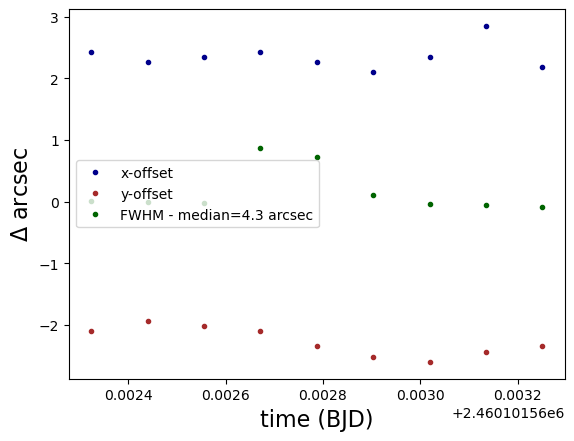

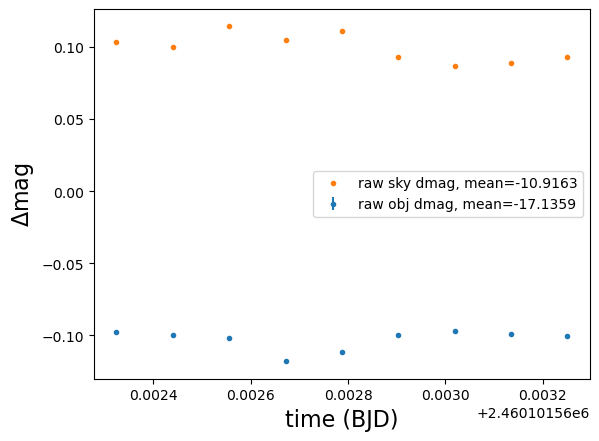

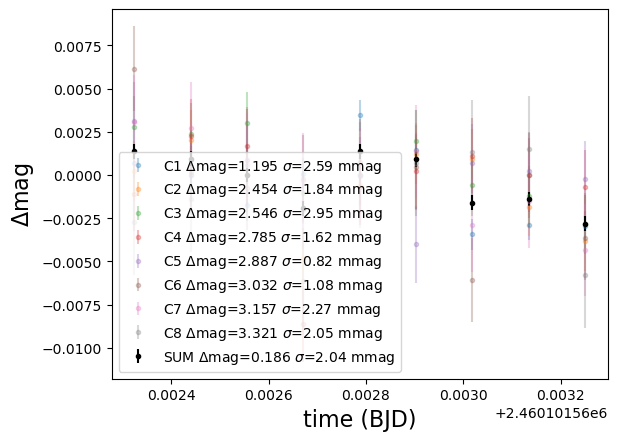

<Table length=9>
       TIME                x                 y         ...        magsum             magsum_err            diffmagsum      
     float64            float64           float64      ...       float64              float64               float64        
------------------ ----------------- ----------------- ... ------------------- --------------------- ----------------------
 2460101.563250399 727.3271690234785 934.3729773105366 ... -16.952680342542255  0.006127492847748459  -0.002806934161206698
 2460101.562555667 727.8271690234785 935.3729773105366 ... -16.948653705679316 0.0061923921545186415                    0.0
2460101.5626714495 728.0771690234785 935.1229773105366 ...  -16.93407647589065  0.006230876403563627 -0.0019150430262264706
2460101.5630188216 727.8271690234785 933.6229773105366 ...  -16.95456115424261  0.006142940276454549  -0.001599571045776571
2460101.5631346046 729.3271690234785 934.1229773105366 ... -16.952491895915248 0.0061446400915955764 -0.0013958244891867366
 2460101.562787244 727.5771690234785 934.3729773105366 ... -16.937423207851808  0.006220366437949425  0.0013788883696825849
 2460101.562903027 727.0771690234785 933.8729773105366 ... -16.949158917676368  0.006176208700750764  0.0008980881980988897
 2460101.562439872 727.5771690234785 935.6229773105366 ... -16.949231955642972 0.0061560848929391255   0.000938682781356448
 2460101.562324089 728.0771690234785 935.1229773105366 ... -16.950793963590133  0.006148500374922951    0.00137884615628181

In [12]:
# Select target index
target = 0
# Select comparisons 
comps = [1, 2, 3, 4, 5, 6, 7, 8]

# plot light curve
s4plt.plot_light_curve(phot_ts_product,
                            target=target,
                            comps=comps,
                            nsig=10,
                            plot_coords=True,
                            plot_rawmags=True,
                            plot_sum=True,
                            plot_comps=True,
                            catalog_name=p['PHOT_REF_CATALOG_NAME'])